In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [7]:
df = pd.read_csv('./data/HAM10000_metadata.csv')
dataset_path = './data'


In [8]:
df['image_id'] = df['image_id'].astype(str) + '.jpg'

In [ ]:
df

In [9]:
# tạo nhãn label nhị phân

df['labels'] = df['dx'].apply(lambda x: '1' if x == 'mel' else '0')
df[['image_id', 'labels']]

,image_id,labels
0,ISIC_0027419.jpg,0
1,ISIC_0025030.jpg,0
2,ISIC_0026769.jpg,0
3,ISIC_0025661.jpg,0
4,ISIC_0031633.jpg,0
...,...,...
10010,ISIC_0033084.jpg,0
10011,ISIC_0033550.jpg,0
10012,ISIC_0033536.jpg,0
10013,ISIC_0032854.jpg,0


In [46]:

# # chia dataset thành 3 phân train val test 80 10 10
# train_df, test_df = train_test_split(df, stratify=df['labels'], test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(test_df, stratify=df['labels'], test_size=0.5, random_state=42)

In [10]:
# Data augmentation and preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize giá trị pixel
    rotation_range=20,  # xoay ảnh
    horizontal_flip=True,  # lật ảnh
    zoom_range=0.2,  # phóng to ảnh
    width_shift_range=0.2, # dịch trái phải
    height_shift_range=0.2,  # dịch lên xuống
    fill_mode='nearest',  # fill pixel
    validation_split=0.2  # chia 80 20
)
train_data = datagen.flow_from_dataframe(
    df,
    directory =dataset_path,
    x_col='image_id',
    y_col='labels',
    target_size = img_size,
    batch_size=32,
    shuffle= True,
    class_mode = 'binary',
    subset = 'training'
)

val_data = datagen.flow_from_dataframe(
    df,
    directory=dataset_path,
    x_col='image_id',
    y_col='labels',
    target_size=img_size,
    batch_size=32,
    shuffle=False,
    class_mode='binary',
    subset = 'validation'
)


Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


In [48]:
from sklearn.utils.class_weight import compute_class_weight
labels = df['labels'].values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict = {i: class_weights_dict[i] for i in range(len(class_weights_dict))}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.5625140417883622), 1: np.float64(4.499101527403414)}


In [3]:
from tensorflow.keras.applications import EfficientNetV2B0, ResNet50, VGG16, MobileNetV2

models_to_build = {
    'EfficientNetV2B0': EfficientNetV2B0,
    'ResNet50': ResNet50,
    'VGG16': VGG16,
    'MobileNetV2': MobileNetV2
}

In [ ]:
def build_model(model_name, input=(224, 224, 3)):
    if model_name not in models_to_build:
        raise ValueError(f"Model {model_name} is not supported. Choose from {list(models_to_build.keys())}.")
    
    base_model = models_to_build[model_name](input_shape=input, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model for fine-tuning
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Assuming 2 classes for melanoma detection
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

result = {}
for model_name in models_to_build.keys():
    print(f"dang build model: {model_name}")
    model = build_model(model_name)
    
    # Train the model
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        class_weight=class_weights_dict,
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    result[model_name] = val_acc,
    # Save the model
    model.save(f'{model_name}_melanoma_detection.h5')

dang build model: EfficientNetV2B0


c:\Users\mquan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9246 - auc_2: 0.4992 - loss: 0.4488 - precision_2: 0.0573 - recall_2: 0.0474 - val_accuracy: 0.6046 - val_auc_2: 0.5000 - val_loss: 0.6946 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.9608 - auc_2: 0.4825 - loss: 0.4171 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6046 - val_auc_2: 0.5498 - val_loss: 0.6786 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9565 - auc_2: 0.5060 - loss: 0.4330 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6046 - val_auc_2: 0.5000 - val_loss: 0.6975 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9646 - auc_2: 0.4832 - loss: 0.3845 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6046 - val_auc_2: 0.5000 

dang build model: ResNet50
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 856s 3s/step - accuracy: 0.9186 - auc_3: 0.5240 - loss: 0.4258 - precision_3: 0.0561 - recall_3: 0.0721 - val_accuracy: 0.6046 - val_auc_3: 0.5760 - val_loss: 0.7039 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - accuracy: 0.9587 - auc_3: 0.5429 - loss: 0.4050 - precision_3: 0.1267 - recall_3: 0.0076 - val_accuracy: 0.6046 - val_auc_3: 0.4996 - val_loss: 0.7358 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 800s 3s/step - accuracy: 0.9622 - auc_3: 0.4495 - loss: 0.4147 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.6046 - val_auc_3: 0.5391 - val_loss: 0.6828 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.9612 - auc_3: 0.4791 - loss: 0.4080 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.6046 -

dang build model: VGG16
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2591s 10s/step - accuracy: 0.9061 - auc_4: 0.5674 - loss: 0.4005 - precision_4: 0.0504 - recall_4: 0.0779 - val_accuracy: 0.5951 - val_auc_4: 0.6209 - val_loss: 0.6595 - val_precision_4: 0.4767 - val_recall_4: 0.2449
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2567s 10s/step - accuracy: 0.9252 - auc_4: 0.8111 - loss: 0.3059 - precision_4: 0.2036 - recall_4: 0.3400 - val_accuracy: 0.5926 - val_auc_4: 0.6164 - val_loss: 0.6924 - val_precision_4: 0.4841 - val_recall_4: 0.4609
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2586s 10s/step - accuracy: 0.8842 - auc_4: 0.8361 - loss: 0.2962 - precision_4: 0.1621 - recall_4: 0.4689 - val_accuracy: 0.5881 - val_auc_4: 0.6191 - val_loss: 0.6943 - val_precision_4: 0.4810 - val_recall_4: 0.5278
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2601s 10s/step - accuracy: 0.8892 - auc_4: 0.8450 - loss: 0.2846 - precision_4: 0.1876 - recall_4: 0.5638 - val_accuracy: 0.5746 - val_auc_4: 0.6070 - val_loss: 0.72

dang build model: MobileNetV2
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.8773 - auc_5: 0.7149 - loss: 0.3937 - precision_5: 0.1292 - recall_5: 0.3307 - val_accuracy: 0.5532 - val_auc_5: 0.5352 - val_loss: 0.8538 - val_precision_5: 0.4246 - val_recall_5: 0.3662
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8858 - auc_5: 0.8571 - loss: 0.2880 - precision_5: 0.1886 - recall_5: 0.5465 - val_accuracy: 0.5771 - val_auc_5: 0.5343 - val_loss: 1.0864 - val_precision_5: 0.3721 - val_recall_5: 0.1010
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8840 - auc_5: 0.8586 - loss: 0.2939 - precision_5: 0.1961 - recall_5: 0.5347 - val_accuracy: 0.5512 - val_auc_5: 0.5356 - val_loss: 1.0339 - val_precision_5: 0.4066 - val_recall_5: 0.2942
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.8819 - auc_5: 0.8614 - loss: 0.2844 - precision_5: 0.1745 - recall_5: 0.5211 - val_accuracy: 0.5607 - val_auc_5: 0.5073 - val_loss: 1.0157

In [12]:
from tensorflow.keras.models import load_model
valloss = {}
valacc = {}
valprecision = {}
valrecall = {}
for i in models_to_build.keys():
    model = load_model(f'{i}_melanoma_detection.h5')
    print(f"Model {i} loaded successfully.")
    # Evaluate the model on validation data
    val_loss, val_acc, val_auc, val_precision, val_recall = model.evaluate(val_data)
    valloss[i] = val_loss
    valacc[i] = val_acc
    valprecision[i] = val_precision
    valrecall[i] = val_recall
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, AUC: {val_auc}, Precision: {val_precision}, Recall: {val_recall}")

Model EfficientNetV2B0 loaded successfully.
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8991 - auc_2: 0.2309 - loss: 0.4788 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Validation Loss: 0.6785898804664612, Validation Accuracy: 0.6045930981636047, AUC: 0.545998215675354, Precision: 0.0, Recall: 0.0


Model ResNet50 loaded successfully.
63/63 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8991 - auc_3: 0.2360 - loss: 0.4608 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00
Validation Loss: 0.6827502250671387, Validation Accuracy: 0.6045930981636047, AUC: 0.5475497841835022, Precision: 0.0, Recall: 0.0


Model VGG16 loaded successfully.
63/63 ━━━━━━━━━━━━━━━━━━━━ 604s 10s/step - accuracy: 0.7521 - auc_4: 0.2423 - loss: 0.4990 - precision_4: 0.1103 - recall_4: 0.0793
Validation Loss: 0.6563206315040588, Validation Accuracy: 0.5926110744476318, AUC: 0.626731276512146, Precision: 0.4695431590080261, Recall: 0.23358586430549622


Model MobileNetV2 loaded successfully.
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6466 - auc_5: 0.2098 - loss: 0.6492 - precision_5: 0.0986 - recall_5: 0.1210
Validation Loss: 0.8564184308052063, Validation Accuracy: 0.5526710152626038, AUC: 0.5341811180114746, Precision: 0.4197530746459961, Recall: 0.34343433380126953


<Figure size 2000x2000 with 0 Axes>

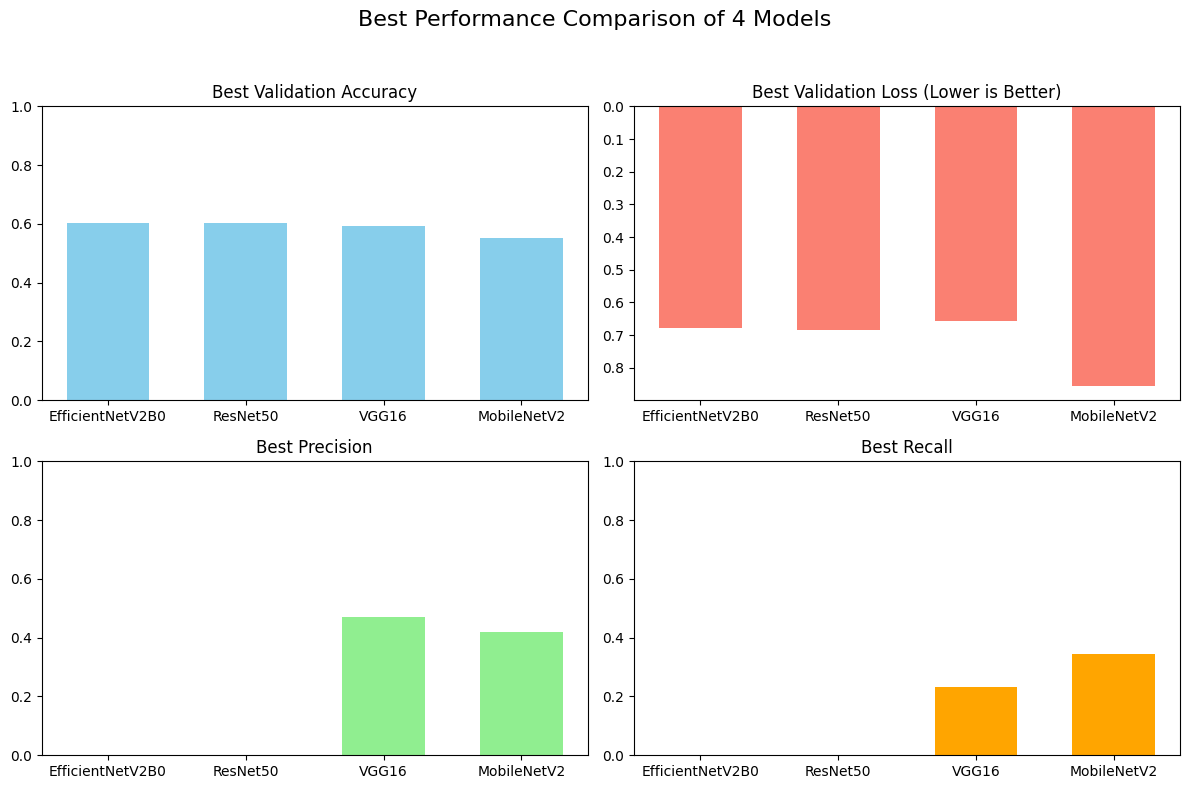

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))

x = np.arange(4)
width = 0.6

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Best Performance Comparison of 4 Models', fontsize=16)

# Accuracy
axs[0, 0].bar(x, valacc.values(), width, color='skyblue')
axs[0, 0].set_title('Best Validation Accuracy')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(valacc.keys())
axs[0, 0].set_ylim(0, 1)

# Loss
axs[0, 1].bar(x, valloss.values(), width, color='salmon')
axs[0, 1].set_title('Best Validation Loss (Lower is Better)')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(valloss.keys())
axs[0, 1].invert_yaxis()  # Optional: makes "lower is better" more visible

# Precision
axs[1, 0].bar(x, valprecision.values(), width, color='lightgreen')
axs[1, 0].set_title('Best Precision')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(valprecision.keys())
axs[1, 0].set_ylim(0, 1)

# Recall
axs[1, 1].bar(x, valrecall.values(), width, color='orange')
axs[1, 1].set_title('Best Recall')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(valrecall.keys())
axs[1, 1].set_ylim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

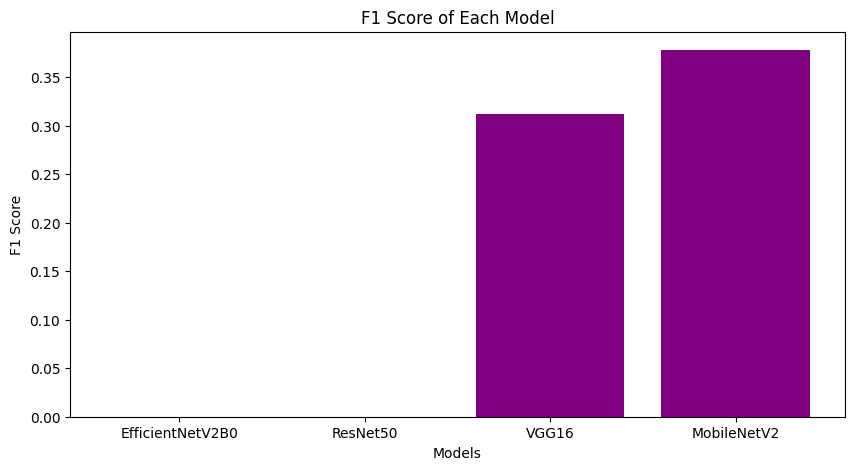

In [17]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0.0  # tránh chia cho 0
    return 2 * (precision * recall) / (precision + recall)
f1_scores = {model: f1_score(valprecision[model], valrecall[model]) for model in valprecision.keys()}
plt.figure(figsize=(10, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='purple')
plt.title('F1 Score of Each Model')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.show()
